### Import the libraries

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sb
from sklearn.preprocessing import LabelEncoder

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from graphviz import Source
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
import time

### Reading data

In [119]:
#Reading the data
df = pd.read_csv("winequality-red.csv")
df.rename(columns={"fixed acidity":"fixed_acidity", "residual sugar":"residual_sugar","volatile acidity":"volatile_acidity", "citric acid": "citric_acid", "free sulfur dioxide":"free_sulfur_dioxide","total sulfur dioxide":"total_sulfur_dioxide"}, inplace= True)
df.shape

(1599, 12)

### Check data details

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [121]:
df.isnull().sum() # no null or Nan values.

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [122]:
df.describe(include='all')

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [123]:
#sb.set()
#sb.pairplot(df, height = 2.5)
#plt.show()

### Preprocessing of data

In [124]:
#labeling the column "quality"
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [125]:
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

In [126]:
df['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

### Visualizing feature significance

<AxesSubplot:>

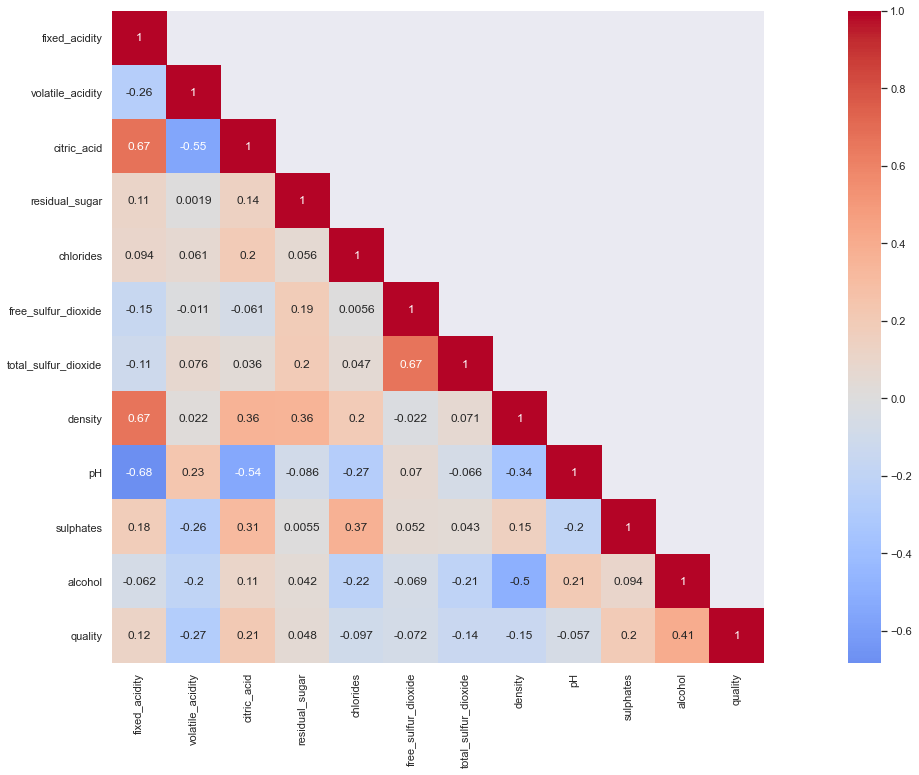

In [127]:
cor_mat= df.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sb.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True,cmap='coolwarm',center=0)

<function matplotlib.pyplot.show(close=None, block=None)>

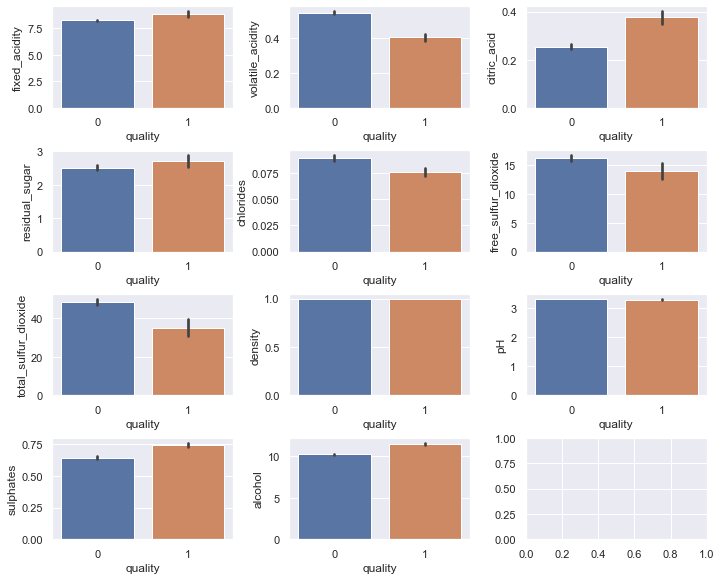

In [128]:
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(10, 8))
ax = ax.flatten()
index=0
for i in df.columns:
  if i != 'quality':
    sb.barplot(x='quality', y=i, data=df, ax=ax[index])
    index+=1
plt.tight_layout(pad=0.4)
plt.show

[0.07853254 0.10306662 0.09449173 0.07107067 0.06833032 0.06899901
 0.08598766 0.0803225  0.06572307 0.10746446 0.17601143]


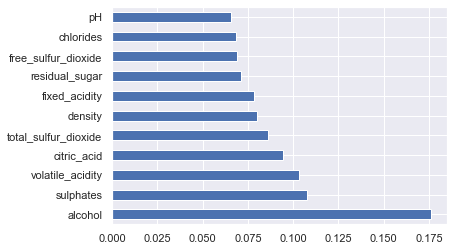

In [129]:
model = ExtraTreesClassifier()
x_feat = df.iloc[:,:-1]
y_feat = df.iloc[:,-1]
model.fit(x_feat,y_feat)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=x_feat.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

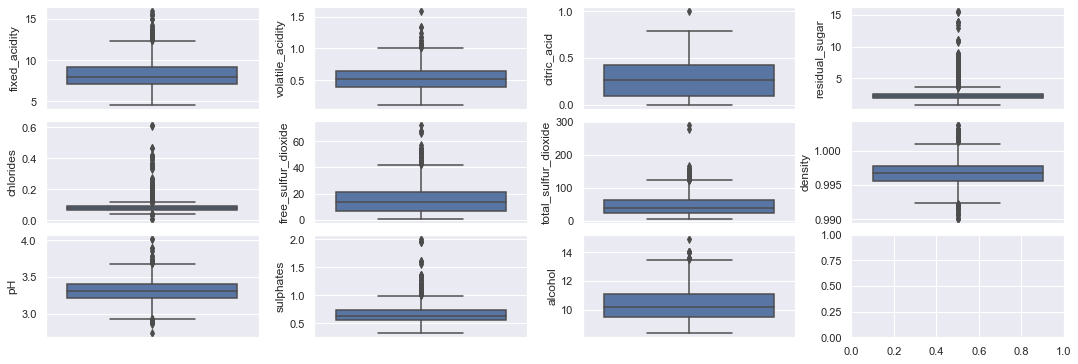

In [130]:
#Plotting boxplots to see if there are any outliers in our data (considering data betwen 25th and 75th percentile as non outlier)
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(15, 5))
ax = ax.flatten()
index = 0
for i in df.columns:
  if i != 'quality':
    sb.boxplot(y=i, data=df, ax=ax[index])
    index +=1
plt.tight_layout(pad=0.4)
plt.show()

In [131]:
#Remove outliers
#For each column, first it computes the Z-score of each value in the column, relative to the column mean and standard deviation.
#Then is takes the absolute of Z-score because the direction does not matter, only if it is below the threshold.
#all(axis=1) ensures that for each row, all column satisfy the constraint.
#Finally, result of this condition is used to index the dataframe.

df = df[(np.abs(zscore(df))<3).all(axis=1)]

### Separating dependent and independent variables

In [132]:
x_fs = df.iloc[:,:-1]
x_fs = x_fs.drop(["free_sulfur_dioxide","fixed_acidity", "citric_acid", "density"], axis = 1)
x_pca = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [133]:
sc = StandardScaler()
x_fsScaled = sc.fit_transform(x_fs)
x_pcaScaled = sc.fit_transform(x_pca)

## To create PCA dataset

In [134]:
pca = PCA()
results = pca.fit(x_pcaScaled)
x_pca = results.transform(x_pcaScaled)

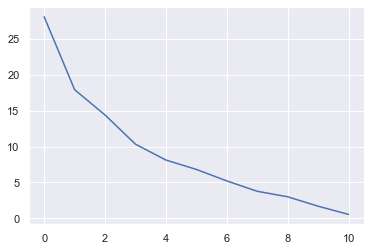

In [135]:
sb.set()
plt.plot(results.explained_variance_ratio_*100)
plt.show()

In [136]:
pca_new = PCA(n_components=5)
x_pca_new = pca_new.fit_transform(x_pcaScaled)

### Splitting test set and training set

In [137]:
x_train_fs, x_test_fs, y_train_fs, y_test_fs = train_test_split(x_fsScaled,y,test_size = 0.25,random_state = 47)

In [138]:
pd.Series(y_train_fs).value_counts()

0    943
1    150
Name: quality, dtype: int64

In [139]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca_new,y,test_size = 0.25,random_state = 47)

In [140]:
pd.Series(y_train_pca).value_counts()

0    943
1    150
Name: quality, dtype: int64

### Normalizing the training set

In [141]:
smote = SMOTE(random_state = 47)
x_oversample_fs, y_oversample_fs = smote.fit_resample(x_train_fs, y_train_fs)

In [142]:
pd.Series(y_oversample_fs).value_counts()

1    943
0    943
Name: quality, dtype: int64

In [143]:
smote = SMOTE(random_state = 47)
x_oversample_pca, y_oversample_pca = smote.fit_resample(x_train_pca, y_train_pca)

In [144]:
pd.Series(y_oversample_pca).value_counts()

1    943
0    943
Name: quality, dtype: int64

# Logistic Regression

#### Feature Selection

In [145]:
start_lr_fs = time.time()
logReg = LogisticRegression()
logReg.fit(x_oversample_fs, y_oversample_fs)
y_pred_logReg_fs = logReg.predict(x_test_fs)
end_lr_fs = time.time()

In [146]:
print(classification_report(y_test_fs, y_pred_logReg_fs))
print('Accuracy is : ', accuracy_score(y_test_fs, y_pred_logReg_fs))
print(confusion_matrix(y_test_fs, y_pred_logReg_fs))
print('Runtime is : ',end_lr_fs - start_lr_fs)

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       314
           1       0.43      0.84      0.57        51

    accuracy                           0.82       365
   macro avg       0.70      0.83      0.73       365
weighted avg       0.89      0.82      0.84       365

Accuracy is :  0.8191780821917808
[[256  58]
 [  8  43]]
Runtime is :  0.0044634342193603516


#### PCA

In [147]:
start_lr_pca = time.time()
logReg = LogisticRegression()
logReg.fit(x_oversample_pca, y_oversample_pca)
y_pred_logReg_pca = logReg.predict(x_test_pca)
end_lr_pca = time.time()

In [148]:
print(classification_report(y_test_pca, y_pred_logReg_pca))
print('Accuracy is : ', accuracy_score(y_test_pca, y_pred_logReg_pca))
print(confusion_matrix(y_test_pca, y_pred_logReg_pca))
print('Runtime is : ',end_lr_pca - start_lr_pca)

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       314
           1       0.40      0.80      0.54        51

    accuracy                           0.81       365
   macro avg       0.68      0.80      0.71       365
weighted avg       0.88      0.81      0.83       365

Accuracy is :  0.8054794520547945
[[253  61]
 [ 10  41]]
Runtime is :  0.0039675235748291016


# K-Nearest Neighbors

#### Feature Selection

In [149]:
start_knn_fs = time.time()
knn = KNeighborsClassifier()
knn.fit(x_oversample_fs, y_oversample_fs)
y_pred_knn_fs = knn.predict(x_test_fs)
end_knn_fs = time.time()

In [150]:
print(classification_report(y_test_fs, y_pred_knn_fs))
print('Accuracy is : ', accuracy_score(y_test_fs, y_pred_knn_fs))
print(confusion_matrix(y_test_fs, y_pred_knn_fs))
print('Runtime is : ', end_knn_fs - start_knn_fs)

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       314
           1       0.43      0.82      0.57        51

    accuracy                           0.82       365
   macro avg       0.70      0.82      0.73       365
weighted avg       0.89      0.82      0.84       365

Accuracy is :  0.8246575342465754
[[259  55]
 [  9  42]]
Runtime is :  0.01188349723815918


#### PCA

In [151]:
start_knn_PCA = time.time()
knn = KNeighborsClassifier()
knn.fit(x_oversample_pca, y_oversample_pca)
y_pred_knn_pca = knn.predict(x_test_pca)
end_knn_PCA = time.time()

In [152]:
print(classification_report(y_test_pca, y_pred_knn_pca))
print('Accuracy is : ', accuracy_score(y_test_pca, y_pred_knn_pca))
print(confusion_matrix(y_test_pca, y_pred_knn_pca))
print('Runtime is : ', end_knn_PCA - start_knn_PCA)

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       314
           1       0.42      0.84      0.56        51

    accuracy                           0.81       365
   macro avg       0.69      0.83      0.72       365
weighted avg       0.89      0.81      0.84       365

Accuracy is :  0.8136986301369863
[[254  60]
 [  8  43]]
Runtime is :  0.004959583282470703


# Decision Tree

In [153]:
start_dt_fs = time.time()
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(x_oversample_fs, y_oversample_fs)
y_pred_dt_fs = dt.predict(x_test_fs)
end_dt_fs = time.time()

### Model Evaluation - Decision Tree

In [154]:
print(classification_report(y_test_fs, y_pred_dt_fs))
print('Accuracy is : ', accuracy_score(y_test_fs, y_pred_dt_fs))
print(confusion_matrix(y_test_fs, y_pred_dt_fs))
print('Runtime is : ', end_dt_fs - start_dt_fs)

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       314
           1       0.52      0.71      0.60        51

    accuracy                           0.87       365
   macro avg       0.74      0.80      0.76       365
weighted avg       0.89      0.87      0.88       365

Accuracy is :  0.8684931506849315
[[281  33]
 [ 15  36]]
Runtime is :  0.009424448013305664


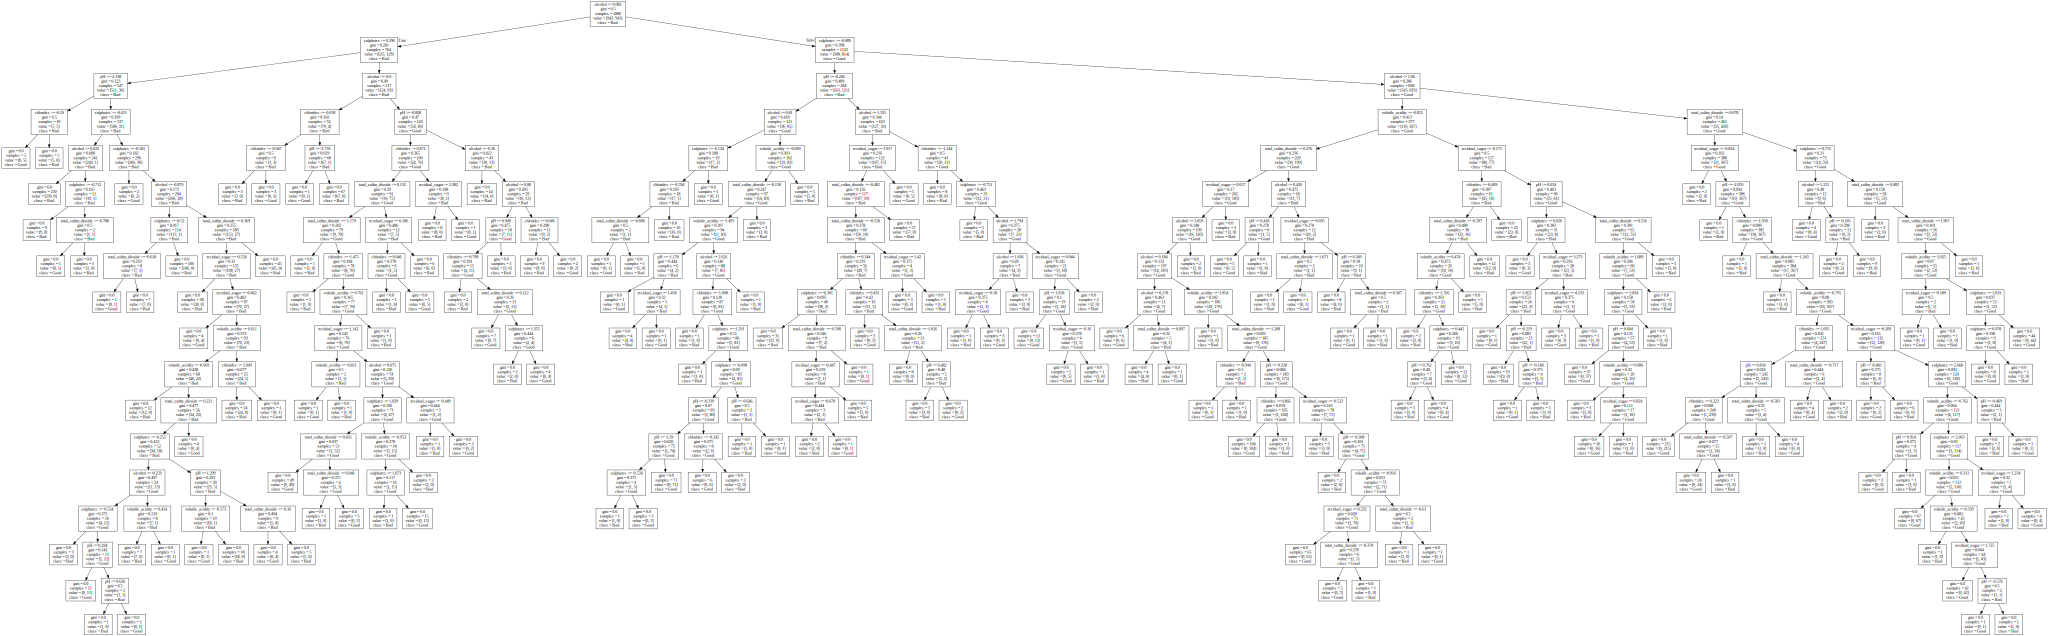

In [155]:
y_pred_dt_fs=dt.predict(x_test_fs)
Source(tree.export_graphviz(dt, out_file=None, class_names=["Bad","Good"], feature_names= x_fs.columns))

In [156]:
start_dt_pca = time.time()
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(x_oversample_pca, y_oversample_pca)
y_pred_dt_pca = dt.predict(x_test_pca)
end_dt_pca = time.time()

In [157]:
print(classification_report(y_test_pca, y_pred_dt_pca))
print('Accuracy is : ', accuracy_score(y_test_pca, y_pred_dt_pca))
print(confusion_matrix(y_test_pca, y_pred_dt_pca))
print('Runtime is : ', end_dt_pca - start_dt_pca)

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       314
           1       0.45      0.67      0.54        51

    accuracy                           0.84       365
   macro avg       0.69      0.77      0.72       365
weighted avg       0.87      0.84      0.85       365

Accuracy is :  0.8383561643835616
[[272  42]
 [ 17  34]]
Runtime is :  0.006943941116333008


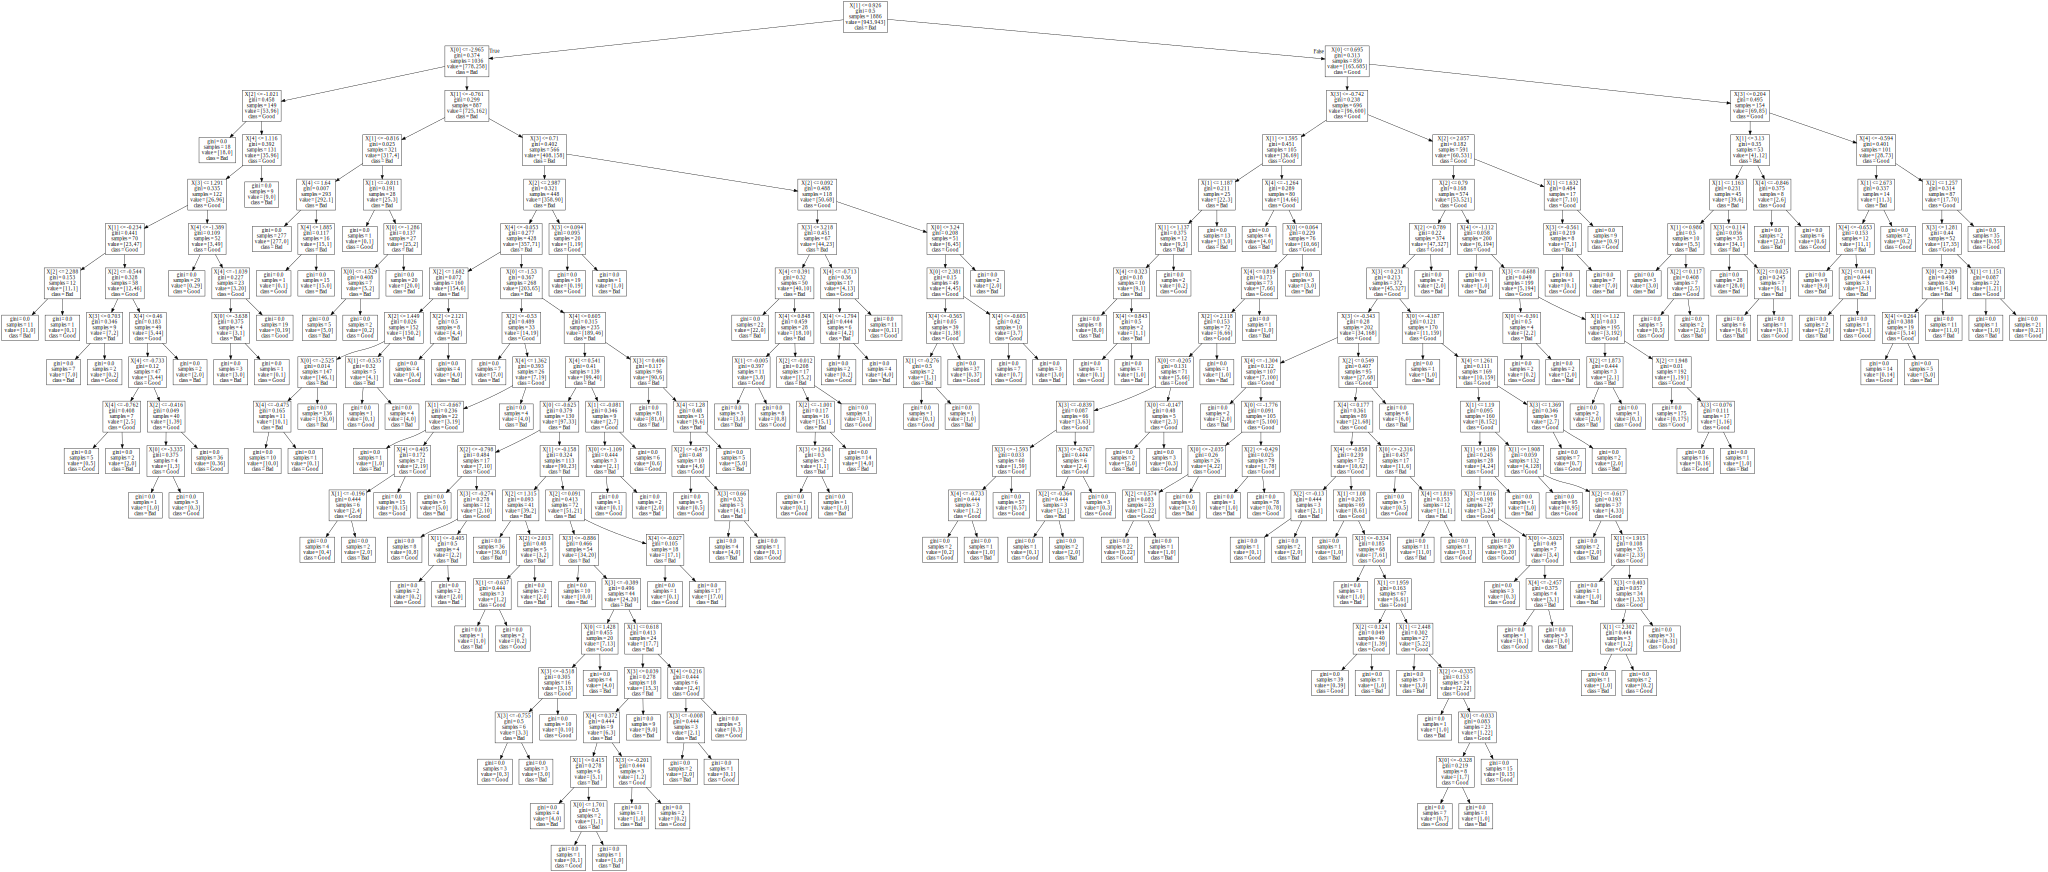

In [158]:
y_pred_dt_pca=dt.predict(x_test_pca)
Source(tree.export_graphviz(dt, out_file=None, class_names=["Bad","Good"]))

## Hyperparameter tuning

### Logistic Regression

#### Feature Selection

In [159]:
solvers = ['newton-cg', 'lbfgs','sag', 'saga','liblinear']
c_params = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,C=c_params)

logReg = LogisticRegression()
grid_logReg = GridSearchCV(estimator= logReg, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_logReg_result_fs = grid_logReg.fit(x_oversample_fs, y_oversample_fs)

In [160]:
#Best mean cross validation score
grid_logReg_result_fs.best_score_

0.8414621138759071

In [161]:
grid_logReg_result_fs.best_estimator_

LogisticRegression(C=100, solver='newton-cg')

In [162]:
#Using best parameters
start_lr_tuned_fs = time.time()

logReg_tuned_fs = LogisticRegression(solver='newton-cg',C=100)
logReg_tuned_fs.fit(x_oversample_fs, y_oversample_fs)
y_pred_logReg_tuned_fs = logReg_tuned_fs.predict(x_test_fs)

end_lr_tuned_fs = time.time()
print(end_lr_tuned_fs - start_lr_tuned_fs)

print("Accuracy score: %f" % accuracy_score(y_test_fs, y_pred_logReg_tuned_fs))
print(confusion_matrix(y_test_fs,y_pred_logReg_tuned_fs))
print(classification_report(y_test_fs, y_pred_logReg_tuned_fs))

0.009918689727783203
Accuracy score: 0.819178
[[256  58]
 [  8  43]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       314
           1       0.43      0.84      0.57        51

    accuracy                           0.82       365
   macro avg       0.70      0.83      0.73       365
weighted avg       0.89      0.82      0.84       365



#### PCA

In [163]:
grid_logReg_result_pca = grid_logReg.fit(x_oversample_pca, y_oversample_pca)

In [164]:
#Best mean cross validation score
grid_logReg_result_pca.best_score_

0.8138787138787139

In [165]:
grid_logReg_result_pca.best_estimator_

LogisticRegression(C=100, solver='newton-cg')

In [166]:
#Using best parameters
start_lr_tuned_pca = time.time()

logReg_tuned_pca = LogisticRegression(solver='newton-cg',C=100)
logReg_tuned_pca.fit(x_oversample_pca, y_oversample_pca)
y_pred_logReg_tuned_pca = logReg_tuned_pca.predict(x_test_pca)

end_lr_tuned_pca = time.time()
print(end_lr_tuned_pca - start_lr_tuned_pca)

print("Accuracy score: %f" % accuracy_score(y_test_pca, y_pred_logReg_tuned_pca))
print(confusion_matrix(y_test_pca,y_pred_logReg_tuned_pca))
print(classification_report(y_test_pca, y_pred_logReg_tuned_pca))

0.007936477661132812
Accuracy score: 0.805479
[[253  61]
 [ 10  41]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       314
           1       0.40      0.80      0.54        51

    accuracy                           0.81       365
   macro avg       0.68      0.80      0.71       365
weighted avg       0.88      0.81      0.83       365



### K-Nearest Neighbors

#### Feature Selection

In [167]:
n_neighbors = range(3, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(estimator= knn, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_knn_result_fs = grid_knn.fit(x_oversample_fs, y_oversample_fs)

In [168]:
#Best mean cross validation score
grid_knn_result_fs.best_score_

0.9178125833298247

In [169]:
grid_knn_result_fs.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [170]:
start_knn_tuned_fs = time.time()

knn_tuned_fs = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
knn_tuned_fs.fit(x_oversample_fs, y_oversample_fs)
y_pred_knn_tuned_fs = knn_tuned_fs.predict(x_test_fs)

end_knn_tuned_fs = time.time()
print(end_knn_tuned_fs - start_knn_tuned_fs)

print("Accuracy score: %f" % accuracy_score(y_test_fs, y_pred_knn_tuned_fs))
print(confusion_matrix(y_test_fs,y_pred_knn_tuned_fs))
print(classification_report(y_test_fs, y_pred_knn_tuned_fs))

0.007936239242553711
Accuracy score: 0.876712
[[279  35]
 [ 10  41]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       314
           1       0.54      0.80      0.65        51

    accuracy                           0.88       365
   macro avg       0.75      0.85      0.79       365
weighted avg       0.91      0.88      0.89       365



#### PCA

In [171]:
grid_knn_result_pca = grid_knn.fit(x_oversample_pca, y_oversample_pca)

In [172]:
#Best mean cross validation score
grid_knn_result_pca.best_score_

0.9241758241758241

In [173]:
grid_knn_result_pca.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [174]:
start_knn_tuned_pca = time.time()

knn_tuned_pca = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
knn_tuned_pca.fit(x_oversample_pca, y_oversample_pca)
y_pred_knn_tuned_pca = knn_tuned_pca.predict(x_test_pca)

end_knn_tuned_pca = time.time()
print(end_knn_tuned_pca - start_knn_tuned_pca)

print("Accuracy score: %f" % accuracy_score(y_test_pca, y_pred_knn_tuned_pca))
print(confusion_matrix(y_test_pca,y_pred_knn_tuned_pca))
print(classification_report(y_test_pca, y_pred_knn_tuned_pca))

0.005456447601318359
Accuracy score: 0.841096
[[267  47]
 [ 11  40]]
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       314
           1       0.46      0.78      0.58        51

    accuracy                           0.84       365
   macro avg       0.71      0.82      0.74       365
weighted avg       0.89      0.84      0.86       365



### Decision Tree

#### Feature selection

##### Plotting train and test score against each hyperparameter get the general ranges for decision tree tuning.

In [175]:
train_accuracy_fs =  []
testing_accuracy_fs = []
for depth in range(1,25):
    dt_test_fs = DecisionTreeClassifier(max_depth = depth,random_state = 0)
    dt_test_fs.fit(x_oversample_fs, y_oversample_fs)
    train_accuracy_fs.append(dt_test_fs.score(x_oversample_fs, y_oversample_fs))
    testing_accuracy_fs.append(dt_test_fs.score(x_test_fs, y_test_fs))

frame_depth_fs = pd.DataFrame({'max_depth': range(1,25), 'train_acc':train_accuracy_fs, 'test_acc':testing_accuracy_fs})

In [176]:
train_accuracy_fs = []
testing_accuracy_fs = []
for split in range(2,100):
    dt_test_fs = DecisionTreeClassifier(min_samples_split = split,random_state = 0)
    dt_test_fs.fit(x_oversample_fs, y_oversample_fs)
    train_accuracy_fs.append(dt_test_fs.score(x_oversample_fs, y_oversample_fs))
    testing_accuracy_fs.append(dt_test_fs.score(x_test_fs, y_test_fs))

frame_split_fs = pd.DataFrame({'min_samples_split':range(2,100), 'train_acc':train_accuracy_fs, 'test_acc':testing_accuracy_fs})

In [177]:
train_accuracy_fs = []
testing_accuracy_fs = []
for leaf in range(2,100):
    dt_test_fs = DecisionTreeClassifier(min_samples_leaf=leaf,random_state = 0)
    dt_test_fs.fit(x_oversample_fs, y_oversample_fs)
    train_accuracy_fs.append(dt_test_fs.score(x_oversample_fs, y_oversample_fs))
    testing_accuracy_fs.append(dt_test_fs.score(x_test_fs, y_test_fs))

frame_leaf_fs = pd.DataFrame({'min_samples_leaf':range(2,100), 'train_acc':train_accuracy_fs, 'test_acc':testing_accuracy_fs})

In [178]:
def train_test_plot(param,frame):
    plt.plot(frame[param], frame['train_acc'], marker ='.', label ="training")
    plt.plot(frame[param], frame['test_acc'], marker ='.', label ="testing")
    plt.xlabel(param)
    plt.ylabel('Performance')
    plt.legend()

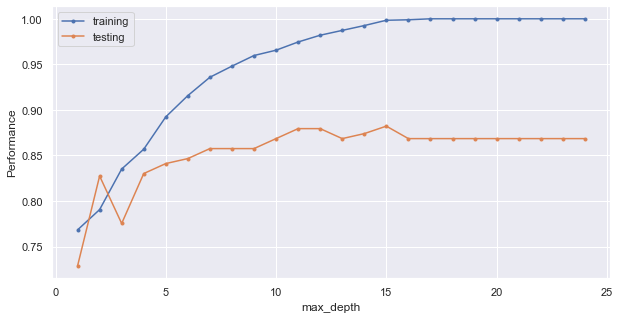

In [204]:
#max_depth
plt.figure(figsize=(10,5))
train_test_plot('max_depth',frame_depth_fs)

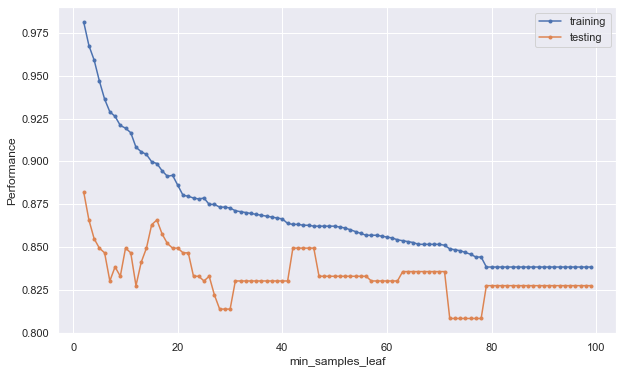

In [180]:
#min_samples_leaf
plt.figure(figsize=(10,5))
train_test_plot('min_samples_leaf',frame_leaf_fs)

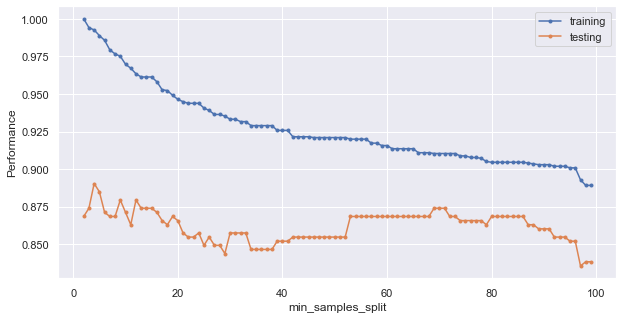

In [203]:
#min_samples_split
plt.figure(figsize=(10,5))
train_test_plot('min_samples_split',frame_split_fs)

In [182]:
max_depth = range(4,16,2)
min_samples_split = range(2,20,1)
min_samples_leaf = range(1,20,1)
criterion = ['gini','entropy']

grid = dict(max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, criterion = criterion)
dt = DecisionTreeClassifier()
grid_dt_fs = GridSearchCV(estimator = dt, param_grid = grid, n_jobs = -1, cv = 5, scoring = 'accuracy')
grid_dt_result_fs = grid_dt_fs.fit(x_oversample_fs, y_oversample_fs)

In [183]:
grid_dt_result_fs.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=4)

In [184]:
grid_dt_result_fs.best_score_

0.8907835459559598

##### Tuning for model using feature scaling

In [185]:
start_dt_tuned_fs= time.time()

dt_tuned_fs = DecisionTreeClassifier(max_depth=10, random_state = 0)
dt_tuned_fs.fit(x_oversample_fs, y_oversample_fs)
y_pred_dt_tuned_fs = dt_tuned_fs.predict(x_test_fs)

end_dt_tuned_fs = time.time()
print(end_dt_tuned_fs - start_dt_tuned_fs)
print("Accuracy score: %f" % accuracy_score(y_test_fs, y_pred_dt_tuned_fs))
print(confusion_matrix(y_test_fs,y_pred_dt_tuned_fs))
print(classification_report(y_test_fs, y_pred_dt_tuned_fs))

0.008927583694458008
Accuracy score: 0.868493
[[282  32]
 [ 16  35]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       314
           1       0.52      0.69      0.59        51

    accuracy                           0.87       365
   macro avg       0.73      0.79      0.76       365
weighted avg       0.89      0.87      0.88       365



#### PCA

##### Plotting train and test score against each hyperparameter get the general ranges for decision tree tuning.

In [186]:
train_accuracy_pca =  []
testing_accuracy_pca = []
for depth in range(1,25): 
    dt_test_pca = DecisionTreeClassifier(max_depth = depth,random_state = 0)
    dt_test_pca.fit(x_oversample_pca, y_oversample_pca)
    train_accuracy_pca.append(dt_test_pca.score(x_oversample_pca, y_oversample_pca))
    testing_accuracy_pca.append(dt_test_pca.score(x_test_pca, y_test_pca))

frame_depth_pca = pd.DataFrame({'max_depth': range(1,25), 'train_acc':train_accuracy_pca, 'test_acc':testing_accuracy_pca})

In [187]:
train_accuracy_pca = []
testing_accuracy_pca = []
for split in range(2,100):
    dt_test_pca = DecisionTreeClassifier(min_samples_split = split,random_state = 0)
    dt_test_pca.fit(x_oversample_pca, y_oversample_pca)
    train_accuracy_pca.append(dt_test_pca.score(x_oversample_pca, y_oversample_pca))
    testing_accuracy_pca.append(dt_test_pca.score(x_test_pca, y_test_pca))

frame_split_pca = pd.DataFrame({'min_samples_split':range(2,100), 'train_acc':train_accuracy_pca, 'test_acc':testing_accuracy_pca})

In [188]:
train_accuracy_pca = []
testing_accuracy_pca = []
for leaf in range(2,100):
    dt_test_pca = DecisionTreeClassifier(min_samples_leaf=leaf,random_state = 0)
    dt_test_pca.fit(x_oversample_pca, y_oversample_pca)
    train_accuracy_pca.append(dt_test_pca.score(x_oversample_pca, y_oversample_pca))
    testing_accuracy_pca.append(dt_test_pca.score(x_test_pca, y_test_pca))

frame_leaf_pca = pd.DataFrame({'min_samples_leaf':range(2,100), 'train_acc':train_accuracy_pca, 'test_acc':testing_accuracy_pca})

In [189]:
def train_test_plot(param,frame):
    plt.plot(frame[param], frame['train_acc'], marker ='.', label ="training")
    plt.plot(frame[param], frame['test_acc'], marker ='.', label ="testing")
    plt.xlabel(param)
    plt.ylabel('Performance')
    plt.legend()

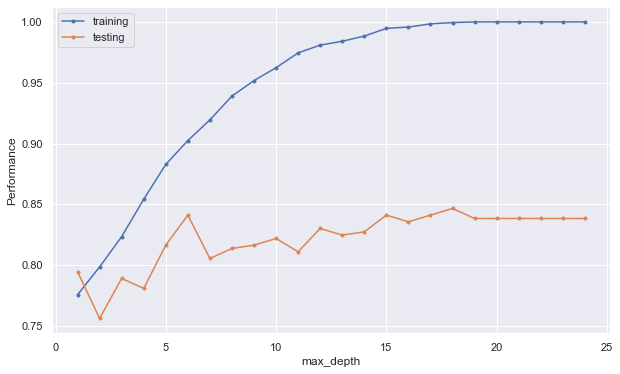

In [190]:
#max_depth
plt.figure(figsize=(10,6))
train_test_plot('max_depth',frame_depth_pca)

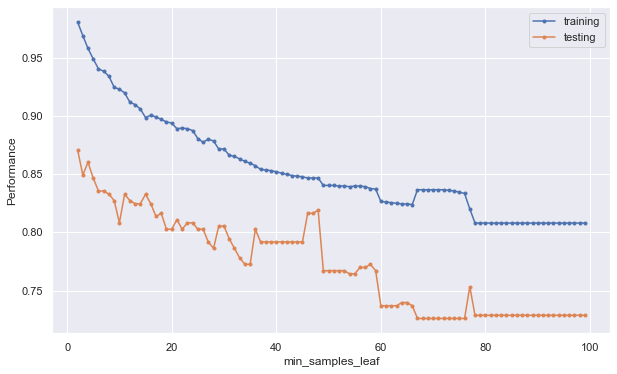

In [191]:
#min_samples_leaf
plt.figure(figsize=(10,6))
train_test_plot('min_samples_leaf',frame_leaf_pca)

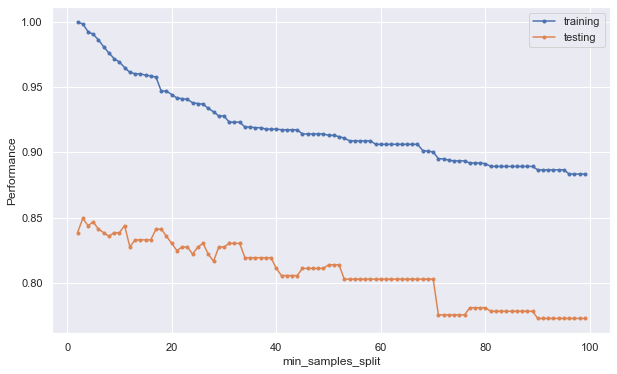

In [192]:
#min_samples_split
plt.figure(figsize=(10,6))
train_test_plot('min_samples_split',frame_split_pca)

In [193]:
max_depth = range(4,16,2)
min_samples_split = range(2,20,1)
min_samples_leaf = range(1,20,1)
criterion = ['gini','entropy']

grid = dict(max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, criterion = criterion)
dt = DecisionTreeClassifier()
grid_dt_pca = GridSearchCV(estimator = dt, param_grid = grid, n_jobs = -1, cv = 5, scoring = 'accuracy')
grid_dt_result_pca = grid_dt_pca.fit(x_oversample_pca, y_oversample_pca)

In [194]:
grid_dt_result_pca.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_split=3)

In [195]:
grid_dt_result_pca.best_score_

0.8966022483263864

##### Tuning for model using PCA

In [196]:
start_dt_tuned_pca= time.time()

dt_tuned_pca = DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=0)
dt_tuned_pca.fit(x_oversample_pca, y_oversample_pca)
y_pred_dt_tuned_pca = dt_tuned_pca.predict(x_test_pca)

end_dt_tuned_pca = time.time()
print(end_dt_tuned_pca - start_dt_tuned_pca)
print("Accuracy score: %f" % accuracy_score(y_test_pca, y_pred_dt_tuned_pca))
print(confusion_matrix(y_test_pca,y_pred_dt_tuned_pca))
print(classification_report(y_test_pca, y_pred_dt_tuned_pca))

0.009423494338989258
Accuracy score: 0.846575
[[274  40]
 [ 16  35]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       314
           1       0.47      0.69      0.56        51

    accuracy                           0.85       365
   macro avg       0.71      0.78      0.73       365
weighted avg       0.88      0.85      0.86       365



## Conclusion of results

In [197]:
conclusion = pd.DataFrame({'Model': ["Logistics Regression (FS)","K-Nearest Neighbours(FS)","Decision Tree(FS)","Logistics Regression (PCA)","K-Nearest Neighbours(PCA)","Decision Tree(PCA)"],
                           'Accuracy before tuning': [accuracy_score(y_test_fs,y_pred_logReg_fs),accuracy_score(y_test_fs,y_pred_knn_fs),accuracy_score(y_test_fs, y_pred_dt_fs),accuracy_score(y_test_pca,y_pred_logReg_pca),accuracy_score(y_test_pca,y_pred_knn_pca),accuracy_score(y_test_pca, y_pred_dt_pca)],
                           'Accuracy after tuning': [accuracy_score(y_test_fs,y_pred_logReg_tuned_fs),accuracy_score(y_test_fs,y_pred_knn_tuned_fs),accuracy_score(y_test_fs, y_pred_dt_tuned_fs),accuracy_score(y_test_pca,y_pred_logReg_tuned_pca),accuracy_score(y_test_pca,y_pred_knn_tuned_pca),accuracy_score(y_test_pca, y_pred_dt_tuned_pca)]})
print (conclusion.to_string(index=False))

                      Model  Accuracy before tuning  Accuracy after tuning
  Logistics Regression (FS)                0.819178               0.819178
   K-Nearest Neighbours(FS)                0.824658               0.876712
          Decision Tree(FS)                0.868493               0.868493
 Logistics Regression (PCA)                0.805479               0.805479
  K-Nearest Neighbours(PCA)                0.813699               0.841096
         Decision Tree(PCA)                0.838356               0.846575


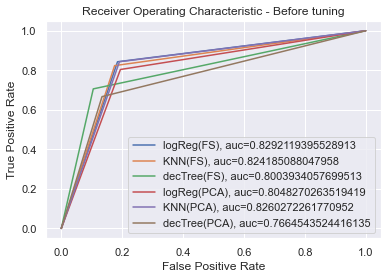

In [198]:
#Plotting of ROC (Before tuning)
from sklearn import metrics
fpr1, tpr1, _ = metrics.roc_curve(y_test_fs,  y_pred_logReg_fs)
auc1 = metrics.roc_auc_score(y_test_fs, y_pred_logReg_fs)
plt.plot(fpr1,tpr1,label="logReg(FS), auc="+str(auc1))
fpr2, tpr2, _ = metrics.roc_curve(y_test_fs, y_pred_knn_fs)
auc2 = metrics.roc_auc_score(y_test_fs, y_pred_knn_fs)
plt.plot(fpr2,tpr2,label="KNN(FS), auc="+str(auc2))
fpr3, tpr3, _ = metrics.roc_curve(y_test_fs, y_pred_dt_fs)
auc3 = metrics.roc_auc_score(y_test_fs, y_pred_dt_fs)
plt.plot(fpr3,tpr3,label="decTree(FS), auc="+str(auc3))

fpr4, tpr4, _ = metrics.roc_curve(y_test_pca,  y_pred_logReg_pca)
auc4 = metrics.roc_auc_score(y_test_pca, y_pred_logReg_pca)
plt.plot(fpr4,tpr4,label="logReg(PCA), auc="+str(auc4))
fpr5, tpr5, _ = metrics.roc_curve(y_test_pca, y_pred_knn_pca)
auc5 = metrics.roc_auc_score(y_test_pca, y_pred_knn_pca)
plt.plot(fpr5,tpr5,label="KNN(PCA), auc="+str(auc5))
fpr6, tpr6, _ = metrics.roc_curve(y_test_pca, y_pred_dt_pca)
auc6 = metrics.roc_auc_score(y_test_pca, y_pred_dt_pca)
plt.plot(fpr6,tpr6,label="decTree(PCA), auc="+str(auc6))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic - Before tuning')
plt.legend(loc=4)
plt.show()

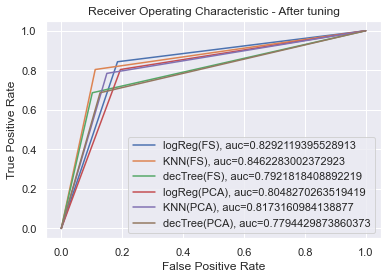

In [199]:
#Plotting of ROC (After tuning)
from sklearn import metrics
fpr1, tpr1, _ = metrics.roc_curve(y_test_fs,  y_pred_logReg_tuned_fs)
auc1 = metrics.roc_auc_score(y_test_fs, y_pred_logReg_tuned_fs)
plt.plot(fpr1,tpr1,label="logReg(FS), auc="+str(auc1))
fpr2, tpr2, _ = metrics.roc_curve(y_test_fs, y_pred_knn_tuned_fs)
auc2 = metrics.roc_auc_score(y_test_fs, y_pred_knn_tuned_fs)
plt.plot(fpr2,tpr2,label="KNN(FS), auc="+str(auc2))
fpr3, tpr3, _ = metrics.roc_curve(y_test_fs, y_pred_dt_tuned_fs)
auc3 = metrics.roc_auc_score(y_test_fs, y_pred_dt_tuned_fs)
plt.plot(fpr3,tpr3,label="decTree(FS), auc="+str(auc3))

fpr4, tpr4, _ = metrics.roc_curve(y_test_pca,  y_pred_logReg_tuned_pca)
auc4 = metrics.roc_auc_score(y_test_pca, y_pred_logReg_tuned_pca)
plt.plot(fpr4,tpr4,label="logReg(PCA), auc="+str(auc4))
fpr5, tpr5, _ = metrics.roc_curve(y_test_pca, y_pred_knn_tuned_pca)
auc5 = metrics.roc_auc_score(y_test_pca, y_pred_knn_tuned_pca)
plt.plot(fpr5,tpr5,label="KNN(PCA), auc="+str(auc5))
fpr6, tpr6, _ = metrics.roc_curve(y_test_pca, y_pred_dt_tuned_pca)
auc6 = metrics.roc_auc_score(y_test_pca, y_pred_dt_tuned_pca)
plt.plot(fpr6,tpr6,label="decTree(PCA), auc="+str(auc6))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic - After tuning')
plt.legend(loc=4)
plt.show()